In [ ]:
import os
import json
import gc
import pickle
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import torch
from transformers import RobertaTokenizer, RobertaModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# ---- Load Dataset ----
with open("combined_dataset.json", "r") as f:
    parsed_data = [json.loads(line) for line in f if line.strip()]
contexts = [sample["Context"] for sample in parsed_data]

# ---- Load Mood Keywords ----
with open("mood_keywords.json", "r", encoding="utf-8") as f:
    mood_keywords = json.load(f)

def detect_mood(text):
    text = text.lower()
    for mood, keywords in mood_keywords.items():
        if any(keyword in text for keyword in keywords):
            return mood
    return None

X_texts, Y_labels = [], []
for context in contexts:
    mood = detect_mood(context)
    if mood:
        X_texts.append(context)
        Y_labels.append(mood)

# ---- Encode Labels (initial) ----
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_labels)
with open("mood_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

label_counts = Counter(Y_encoded)
valid_labels = {label for label, count in label_counts.items() if count > 1}
filtered = [(x, y) for x, y in zip(X_texts, Y_encoded) if y in valid_labels]
X_texts_filtered = [x for x, _ in filtered]
Y_filtered = [y for _, y in filtered]

# ---- RoBERTa Token Embeddings ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base").to(device)
roberta_model.eval()

max_length = 128

def roberta_embed_token_embeddings(texts, batch_size=16, max_length=128):
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(batch, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
            encoded = {k: v.to(device) for k, v in encoded.items()}
            output = roberta_model(**encoded)
            embeddings = output.last_hidden_state.cpu().numpy()
            all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

embedding_file = "roberta_token_embeddings.npy"
texts_file = "roberta_embedding_texts.pkl"
labels_file = "roberta_embedding_labels.pkl"

if os.path.exists(embedding_file) and os.path.exists(texts_file) and os.path.exists(labels_file):
    print("📂 Loading existing RoBERTa token embeddings...")
    X_emb = np.load(embedding_file)
    with open(texts_file, "rb") as f:
        saved_texts = pickle.load(f)
    with open(labels_file, "rb") as f:
        saved_labels = pickle.load(f)
    if len(saved_texts) == len(X_texts_filtered) and len(saved_labels) == len(Y_filtered):
        print("✅ Loaded existing embeddings successfully!")
    else:
        print("⚠️ Saved data mismatch, regenerating embeddings...")
        X_emb = roberta_embed_token_embeddings(X_texts_filtered, max_length=max_length)
        np.save(embedding_file, X_emb)
        with open(texts_file, "wb") as f:
            pickle.dump(X_texts_filtered, f)
        with open(labels_file, "wb") as f:
            pickle.dump(Y_filtered, f)
else:
    print("🔄 Generating RoBERTa token embeddings...")
    X_emb = roberta_embed_token_embeddings(X_texts_filtered, max_length=max_length)
    print("💾 Saving RoBERTa token embeddings...")
    np.save(embedding_file, X_emb)
    with open(texts_file, "wb") as f:
        pickle.dump(X_texts_filtered, f)
    with open(labels_file, "wb") as f:
        pickle.dump(Y_filtered, f)

print(f"Token embedding shape: {X_emb.shape}")

# ---- Resampling with SMOTE after PCA ----
min_samples = min(Counter(Y_filtered).values())

if min_samples < 2:
    print("⚠️ SMOTE skipped due to insufficient samples.")
    X_resampled = X_emb
    Y_resampled_encoded = np.array(Y_filtered)
else:
    # Flatten then reduce dimensionality with PCA
    X_flat = X_emb.reshape(X_emb.shape[0], -1)  # (samples, 128*768)
    print("🔽 Applying PCA to reduce dimensions before SMOTE...")
    pca = PCA(n_components=500, random_state=42)
    X_pca = pca.fit_transform(X_flat)  # (samples, 500)
    
    smote_k = max(1, min(5, min_samples - 1))
    smote = SMOTE(k_neighbors=smote_k, random_state=42)
    X_resampled_pca, Y_resampled_encoded = smote.fit_resample(X_pca, Y_filtered)

    # Optionally map PCA output back to 3D for LSTM input
    X_resampled = np.reshape(X_resampled_pca, (X_resampled_pca.shape[0], 10, 50))  # e.g., 10 timesteps of 50 dims

# ---- Re-encode labels to zero-based continuous indices ----
print("Labels before re-encoding after SMOTE:", np.unique(Y_resampled_encoded))
le = LabelEncoder()
Y_resampled_encoded_zero_based = le.fit_transform(Y_resampled_encoded)
num_classes = len(le.classes_)
print("Labels after re-encoding:", np.unique(Y_resampled_encoded_zero_based))
print("Number of classes:", num_classes)

# ---- One-hot encode labels ----
Y_resampled = to_categorical(Y_resampled_encoded_zero_based, num_classes=num_classes)

# ---- Train/Test Split ----
X_train, X_test, Y_train, Y_test = train_test_split(
    X_resampled, Y_resampled,
    test_size=0.25,
    stratify=Y_resampled_encoded_zero_based,
    random_state=42
)

Y_train_int = np.argmax(Y_train, axis=1)
Y_test_int = np.argmax(Y_test, axis=1)

# ---- Compute class weights ----
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(Y_train_int),
    y=Y_train_int
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# ---- Model Builder ----
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = GlobalMaxPooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# ---- Train Model ----
gc.collect()
model = build_model(input_shape=X_train.shape[1:], num_classes=num_classes)

early_stop = EarlyStopping(monitor="val_loss", patience=9, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=7, min_lr=1e-6, verbose=1)

print("Training data size:", len(X_train))
print("Validation data size:", int(len(X_train)*0.1))
print("Test data size:", len(X_test))

history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# ---- Evaluate ----
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"✅ Test Loss: {loss:.4f} - Test Accuracy: {acc*100:.2f}%")

Y_pred_prob = model.predict(X_test)
Y_pred = np.argmax(Y_pred_prob, axis=1)


In [ ]:
from tensorflow.keras.models import Model,save_model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# ---- Plot Results ----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()
plt.tight_layout()
plt.show()

# ---- F1 Score ----
f1 = f1_score(Y_test_int, Y_pred, average="weighted")
print(f"🎯 Weighted F1 Score: {f1 * 100:.2f}%")

# ---- Save Model ----
from tensorflow.keras.models import save_model
model_path = "moods_classifier_bilstm_model.keras"

# Remove old model if exists
if os.path.exists(model_path):
    try:
        if os.path.isfile(model_path):
            os.remove(model_path)
        else:
            import shutil
            shutil.rmtree(model_path)
        print(f"🧹 Removed old model: {model_path}")
    except Exception as e:
        print(f"❌ Could not delete old model: {e}")
        raise

# Save model
try:
    save_model(model, model_path)
    print(f"✅ Model saved in native Keras format at: {model_path}")
except Exception as e:
    print(f"❌ Error saving model: {e}")


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

In [1]:
# === Imports and Setup ===
import pandas as pd
import numpy as np
import pickle
import os
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
import torch
from transformers import RobertaTokenizer, RobertaModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

# === Load and Clean Dataset ===
df = pd.read_csv("final_cleaned_dataset.csv")
texts = df["question_text"].fillna("").astype(str).tolist()
labels = df["topics"].fillna("").astype(str).tolist()

label_counts = Counter(labels)
valid_labels = {label for label, count in label_counts.items() if count > 1}
filtered = [(x, y) for x, y in zip(texts, labels) if y in valid_labels]
texts_filtered = [x for x, y in filtered]
labels_filtered = [y for x, y in filtered]

# === Encode Labels ===
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_filtered)
with open("mood_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# === Load RoBERTa and Generate Embeddings ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base").to(device)
roberta_model.eval()

def roberta_embed_pooled(texts, batch_size=16, max_length=128):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
            encoded = {k: v.to(device) for k, v in encoded.items()}
            output = roberta_model(**encoded)
            pooled = output.pooler_output
            embeddings.append(pooled.cpu().numpy())
    return np.vstack(embeddings)

embedding_file = "roberta_embeddings.npy"
if os.path.exists(embedding_file):
    print("📂 Loading cached embeddings...")
    X_emb = np.load(embedding_file)
else:
    print("🔄 Generating embeddings...")
    X_emb = roberta_embed_pooled(texts_filtered)
    np.save(embedding_file, X_emb)

# === Balance Data with SMOTE ===
label_counts = Counter(labels_encoded)
min_samples = min(label_counts.values())
k_neighbors_val = min(min_samples - 1, 5) if min_samples > 1 else 1
print(f"SMOTE with k_neighbors={k_neighbors_val}")
smote = SMOTE(random_state=42, k_neighbors=k_neighbors_val)
X_resampled, Y_resampled = smote.fit_resample(X_emb, labels_encoded)

# === One-hot encode with consistent encoder ===
label_encoder_final = LabelEncoder()
Y_encoded = label_encoder_final.fit_transform(Y_resampled)
num_classes = len(np.unique(Y_encoded))
Y_onehot = to_categorical(Y_encoded, num_classes=num_classes)

# Save final label encoder used for chatbot
with open("mood_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder_final, f)

# === Split Dataset ===
X_train, X_test, Y_train, Y_test = train_test_split(
    np.expand_dims(X_resampled, axis=1).astype("float32"),
    Y_onehot.astype("float32"),
    test_size=0.2,
    random_state=42,
    stratify=Y_encoded
)

# === Attention Layer ===
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# === Build Model ===
def build_model(seq_len, embedding_dim, num_classes):
    inp = Input(shape=(seq_len, embedding_dim))
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)))(inp)
    x = Dropout(0.4)(x)
    x = AttentionLayer()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inp, outputs=out)

model = build_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])

# === Class Weights ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_encoded), y=Y_encoded)
class_weight_dict = dict(enumerate(class_weights))


e:\AI ML Models\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\AI ML Models\.venv\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
e:\AI ML Models\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

📂 Loading cached embeddings...
SMOTE with k_neighbors=1


In [ ]:

# === Compile Model ===
model.compile(
    optimizer=Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4, decay_steps=500, decay_rate=0.9)),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Train Model ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=7, min_lr=1e-6),
    ModelCheckpoint("roberta_bilstm_attention_best.keras", save_best_only=True)
]

try:
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=30,
        batch_size=16,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
except (tf.errors.ResourceExhaustedError, tf.errors.InternalError):
    tf.keras.backend.clear_session()
    with tf.device('/CPU:0'):
        model = build_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])
        model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(
            X_train, Y_train,
            validation_data=(X_test, Y_test),
            epochs=15,
            batch_size=32,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )

# === Save Final Model ===
model.save("roberta_bilstm_attention_final.keras")

# === Evaluate Model ===
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"✅ Final Test Accuracy: {acc * 100:.2f}%")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# === Classification Report ===
print("\n🧾 Classification Report:")
if hasattr(label_encoder_final, "classes_"):
    target_names = [str(label) for label in label_encoder_final.classes_]
else:
    target_names = [f"Class {i}" for i in range(Y_test.shape[1])]
print(classification_report(y_true, y_pred, target_names=target_names))

# === Confusion Matrix ===
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(max(8, len(target_names) * 0.5), max(6, len(target_names) * 0.5)))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('📊 Confusion Matrix')
plt.tight_layout()
plt.show()

Epoch 1/15
27609/27609 [==============================] - 216s 8ms/step - loss: 3.4126 - accuracy: 0.3225 - val_loss: 1.4763 - val_accuracy: 0.7152 - lr: 1.0000e-04
Epoch 2/15
27609/27609 [==============================] - 225s 8ms/step - loss: 1.5207 - accuracy: 0.6912 - val_loss: 1.0668 - val_accuracy: 0.7839 - lr: 1.0000e-04
Epoch 3/15
27609/27609 [==============================] - 225s 8ms/step - loss: 1.2268 - accuracy: 0.7480 - val_loss: 0.9340 - val_accuracy: 0.8087 - lr: 1.0000e-04
Epoch 4/15
27609/27609 [==============================] - 215s 8ms/step - loss: 1.1045 - accuracy: 0.7687 - val_loss: 0.8659 - val_accuracy: 0.8214 - lr: 1.0000e-04
Epoch 5/15
27609/27609 [==============================] - 228s 8ms/step - loss: 1.0303 - accuracy: 0.7792 - val_loss: 0.8158 - val_accuracy: 0.8260 - lr: 1.0000e-04
Epoch 6/15
27609/27609 [==============================] - 181s 7ms/step - loss: 0.9763 - accuracy: 0.7878 - val_loss: 0.7737 - val_accuracy: 0.8301 - lr: 1.0000e-04
Epoch 7/15

e:\AI ML Models\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: object of type 'numpy.int64' has no len()

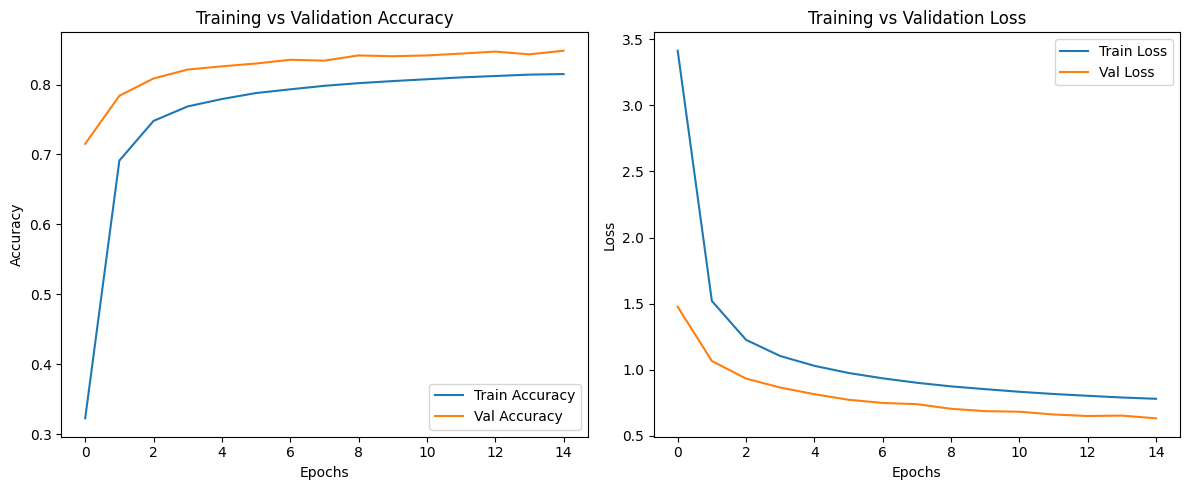

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# === Imports ===
import json
import random
import pickle
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaModel
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
import spacy

# === Custom Attention Layer (for model loading) ===
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# === Load Model and Encoder ===
model = load_model("roberta_bilstm_attention_final.keras", custom_objects={"AttentionLayer": AttentionLayer})
with open("mood_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# === Load RoBERTa ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base").to(device)
roberta_model.eval()

# === Function to Embed Text ===
def embed_text(text):
    inputs = tokenizer([text], padding=True, truncation=True, max_length=128, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    pooled = outputs.pooler_output
    return pooled.cpu().numpy().reshape(1, 1, -1).astype("float32")

# === Context Memory ===
class ContextMemory:
    def __init__(self, max_len=3):
        self.window = []
        self.max_len = max_len

    def add(self, user_input):
        self.window.append(user_input)
        if len(self.window) > self.max_len:
            self.window.pop(0)

    def get_context(self):
        return " ".join(self.window)

context_memory = ContextMemory()

# === Load Response Bank from JSON ===
def load_responses_from_json(file_path="cleaned_questions.json"):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    topic_to_responses = {}
    for entry in data:
        category = entry.get("category", "Unknown")
        questions = []
        for section in entry.get("questions", []):
            questions += section.get("questions", [])
        topic_to_responses[category] = questions
    return topic_to_responses

response_bank = load_responses_from_json()

# === NLP Enrichment with spaCy ===
nlp = spacy.load("en_core_web_sm")

def enrich_with_nlp(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        return f"🧠 NLP Insight — Entities: {entities}"
    return ""

# === Select a Response ===
def select_response(predicted_topic, response_bank):
    responses = response_bank.get(predicted_topic, [])
    if responses:
        return random.choice(responses)
    return "I'm here to support you. Can you share more about how you're feeling?"

# === Final Chatbot Function ===
def chatbot_reply(user_input):
    # Store input in context memory
    context_memory.add(user_input)
    context = context_memory.get_context()

    # Embed context and predict mood/topic
    embedding = embed_text(context)
    prediction = model.predict(embedding, verbose=0)[0]
    predicted_index = np.argmax(prediction)
    predicted_topic = label_encoder.inverse_transform([predicted_index])[0]

    # Get response + NLP insights
    response = select_response(predicted_topic, response_bank)
    nlp_info = enrich_with_nlp(user_input)

    return f"📘 Detected Topic: {predicted_topic}\n💬 Suggested Response: {response}\n{nlp_info}"


ModuleNotFoundError: No module named 'spacy'